# Testing

A large-ish notebook that does some, mostly qualitative, testing of various _explorationlib_ functions.

### Shared imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from explorationlib import agent
from explorationlib import local_gym as gym

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d

from explorationlib.score import summary2d
from explorationlib.score import search_efficient
from explorationlib.score import average_reward
from explorationlib.score import turn_ratio

### Config notebook

In [2]:
%matplotlib inline
%load_ext nb_black
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"

<IPython.core.display.Javascript object>

# Test - random search agents - 1
- First use the `gym.Field`, an open space. Verify the step length distributions, and qualitative behave/position data

In [ ]:
env = gym.Field()

brown = agent.Diffusion2d(scale=1)
levy = agent.Levy2d(exponent=2)
uniform = agent.Uniform2d(scale=1)

In [ ]:
# How long to run? Longer is better, but slower.
num_steps = 5000

# !
experiment("data/uniform.pkl", uniform, env, num_steps=num_steps, num_experiments=1)
experiment("data/levy.pkl", levy, env, num_steps=num_steps, num_experiments=1)
experiment("data/brown.pkl", brown, env, num_steps=num_steps, num_experiments=1)

# Load the results
levy_exp = load("data/levy.pkl")
brown_exp = load("data/brown.pkl")
uni_exp = load("data/uniform.pkl")

### show available data from the experiment

In [ ]:
levy_exp.keys()

### plot position data

In [ ]:
boundary = (100, 100)

plot_position2d(uni_exp, boundary=boundary, title="Uniform", alpha=1)
plot_position2d(brown_exp, boundary=boundary, title="Brownian", alpha=1)
plot_position2d(levy_exp, boundary=boundary, title="Levy", alpha=1)

### plot step length distributions

- _Uniform_ should be flat
- _Diffusion_ should look like a exponential curve
- _Levy_ should be a very steep curve, a power law

In [ ]:
ax_u = plot_length_hist(uni_exp, title="Uniform", loglog=False, bins=50, density=True, alpha=1)
ax_b = plot_length_hist(
    brown_exp, title="Brownian", loglog=False, bins=50, density=True, alpha=1
)
ax_l = plot_length_hist(levy_exp, title="Levy", loglog=False, bins=60, density=True, alpha=1)

### plot loglog length distributions

- _Uniform_ should be flat(ish) still
- _Diffusion_ should drop of quick for large l
- _Levy_ should be a downward going straight line

In [ ]:
ax_u = plot_length_hist(uni_exp, title="Uniform", loglog=True, bins=50, density=True, alpha=1)
ax_b = plot_length_hist(
    brown_exp, title="Brownian", loglog=True, bins=50, density=True, alpha=1
)
ax_l = plot_length_hist(levy_exp, title="Levy", loglog=True, bins=60, density=True, alpha=1)

# Test - random search agents - 2
- Next use the `gym.Field` with various (bounded) target distributions. Verify target gathering performance across agents.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
target_boundary = (10, 10)
dense_targets = gym.uniform_targets(100, target_boundary)
dense_values = gym.constant_values(dense_targets, 1)
sparse_targets = gym.uniform_targets(10, target_boundary)
sparse_values = gym.constant_values(sparse_targets, 1)

Targets should be bound within (-10, 10)

In [ ]:
np.vstack(dense_targets).min(), np.vstack(dense_targets).max()

Values should be 1

In [ ]:
dense_values

Load agents, and the envs

In [ ]:
radius = 0.1  # r_v : detection radius

dense_env = gym.Field()
dense_env.add_targets(dense_targets, dense_values, detection_radius=radius)

sparse_env = gym.Field()
sparse_env.add_targets(sparse_targets, sparse_values, detection_radius=radius)

Plot the targets

In [ ]:
plot_targets2d(dense_env, boundary=target_boundary, title="Dense")
plot_targets2d(sparse_env, boundary=target_boundary, title="Sparse")

### Run 25 experiments
For both _Dense_ and _Sparse_ each with `num_steps`.

In [ ]:
num_experiments = 20
num_steps = 5000

brown = agent.Diffusion2d(scale=1)
levy2 = agent.Levy2d(exponent=2)
levy3 = agent.Levy2d(exponent=3)
uni = agent.Uniform2d(scale=0.1)

In [ ]:
experiment(
    f"data/dense_uniform.pkl",
    uniform,
    dense_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/dense_levy2.pkl",
    levy2,
    dense_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/dense_levy3.pkl",
    levy3,
    dense_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/dense_brown.pkl",
    brown,
    dense_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)

In [ ]:
experiment(
    f"data/sparse_uniform.pkl",
    uniform,
    sparse_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/sparse_levy2.pkl",
    levy2,
    sparse_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/sparse_levy3.pkl",
    levy3,
    sparse_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/sparse_brown.pkl",
    brown,
    sparse_env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)

### Load the results

In [ ]:
uni_dense = load("data/dense_uniform.pkl")
levy2_dense = load("data/dense_levy2.pkl")
levy3_dense = load("data/dense_levy3.pkl")
brown_dense = load("data/dense_brown.pkl")

uni_sparse = load("data/sparse_uniform.pkl")
levy2_sparse = load("data/sparse_levy2.pkl")
levy3_sparse = load("data/sparse_levy3.pkl")
brown_sparse = load("data/sparse_brown.pkl")

### _Dense_ results. 
Bigger mean reward is better

In [ ]:
print(f"Uniform {summary2d(uni_dense)}")
print(f"Levy u=2 {summary2d(levy2_dense)}")
print(f"Levy u=3 {summary2d(levy3_dense)}")
print(f"Diffusion {summary2d(brown_dense)}")

### _Sparse_ results. 

In [ ]:
print(f"Uniform {summary2d(uni_sparse)}")
print(f"Levy u=2 {summary2d(levy2_sparse)}")
print(f"Levy u=3 {summary2d(levy3_sparse)}")
print(f"Diffusion {summary2d(brown_sparse)}")

# Test - random search agents - 3
## Scan the Levy exponent
For sparse renewing targets, small detection radius, a classic ressult is optimal search eff at u=2. Prove that holds.

Params take from (as much as possible):

> Viswanathan, G. M. et al. Optimizing the success of random searches. Nature 401, 911–914 (1999).

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [10]:
# Vins params
# num_targets = 5000
# detection_radius = 1
# target_boundary = (50000, 50000)

# My mod for speed
num_targets = 50000
detection_radius = 1
target_boundary = (5000, 5000)

targets = gym.uniform_targets(num_targets, target_boundary)
values = gym.constant_values(targets, 1)

env = gym.Field()
env.add_targets(targets, values, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

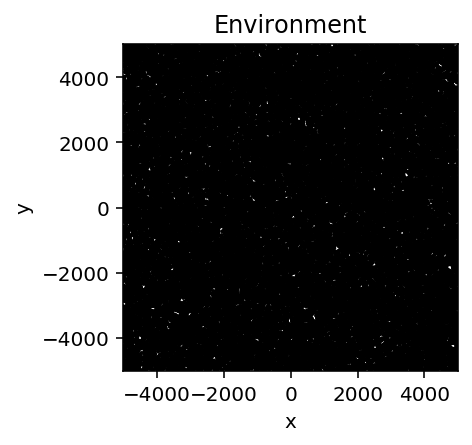

<IPython.core.display.Javascript object>

In [11]:
plot_targets2d(env, boundary=target_boundary, title="Environment")

In [12]:
# Run params
norm = 10
num_experiments = 1
num_steps = 1000
seed = None

# num_exponents = 10
# exponents = np.linspace(1.01, 2.99, num_exponents)
exponents = [1.01, 2.00, 2.99]

# !
scores = []
for x in exponents:
    # Init
    x = np.round(x, 2)
    exp_name = f"data/levy{x}_scan.pkl"
    levy = agent.Levy2d(exponent=x, norm=norm)

    # Run repeats
    experiment(
        exp_name,
        levy,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed,
    )

    # Measure
    exp_data = load(exp_name)
    scores.append(average_reward(exp_data))

    # Progress
    print(x, summary2d(exp_data))

1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
# Vis
plt.plot(exponents, scores)
plt.xlabel("Exponent")
plt.xlabel("Search eff.")

Look at levy u=2 up close

In [ ]:
exp_data = load(f"data/levy2.0_scan.pkl")

# Targets (red), Search (black)
ax = plot_position2d(
    exp_data, boundary=target_boundary, label="Search", figsize=(10, 10)
)
plot_targets2d(
    env, boundary=target_boundary, color="red", alpha=0.8, label="Targets", ax=ax
)

# Lengths and tim
plot_length(exp_data, color="black")